### Importing Packages

In [1]:
import torch
import torchvision
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
# import torchtoolbox.transform as transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
  
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/

'Colab Notebooks'   CS230-Project


In [4]:
#!rm -rf -d /content/drive/MyDrive/*.jpg

### Data Loading

In [5]:
# !unzip /content/drive/MyDrive/CS230-Project/ISIC-subset1.zip -d /content/drive/MyDrive/CS230-Project/Data/ISIC-subset1

In [6]:
train_df = pd.read_csv("/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/train.csv")
print(len(train_df))

33126


In [7]:
 !ls /content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/train/ | wc -l

ls: cannot open directory '/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/train/': Input/output error
0


In [8]:
test_df = pd.read_csv("/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/test.csv")
print(len(test_df))

10982


In [9]:
 !ls /content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/test/ | wc -l

10982


In [10]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [11]:
train_df ['target'].value_counts()[0], train_df ['target'].value_counts()[1]

(32542, 584)

In [12]:
# train_drop_indices = []
# for index, row in train_df.iterrows():
#     im_path = os.path.join('/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/train/', train_df.iloc[index]['image_name'] + '.jpg')
#     if os.path.exists(im_path)== False:
#       train_drop_indices.append(index)

In [13]:
# train_df = train_df.drop(train_df.index[train_drop_indices])
# print(len(train_df))

In [14]:
# test_drop_indices = []
# for index, row in test_df.iterrows():
#     im_path = os.path.join('/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/test/', test_df.iloc[index]['image_name'] + '.jpg')
#     if os.path.exists(im_path)== False:
#       test_drop_indices.append(index)

In [15]:
# test_df = test_df.drop(test_df.index[test_drop_indices])
# print(len(test_df))

### Setting seed values

In [16]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# GPU Specifications
!nvidia-smi

Wed Nov  9 15:38:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
im_path = os.path.join('/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/train/', train_df.iloc[0]['image_name'] + '.jpg')
x = cv2.imread(im_path)
print(type(x))

<class 'numpy.ndarray'>


In [20]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        # x = cv2.imread(im_path)
        # open method used to open different extension image file
        x = Image.open(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)

In [21]:
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [22]:
# class Microscope:
#     """
#     Cutting out the edges around the center circle of the image
#     Imitating a picture, taken through the microscope

#     Args:
#         p (float): probability of applying an augmentation
#     """

#     def __init__(self, p: float = 0.5):
#         self.p = p

#     def __call__(self, img):
#         """
#         Args:
#             img (PIL Image): Image to apply transformation to.

#         Returns:
#             PIL Image: Image with transformation.
#         """
#         if random.random() < self.p:
#             circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
#                         (img.shape[0]//2, img.shape[1]//2), # center point of circle
#                         random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
#                         (0, 0, 0), # color
#                         -1)

#             mask = circle - 255
#             img = np.multiply(img, mask)
        
#         return img

#     def __repr__(self):
#         return f'{self.__class__.__name__}(p={self.p})'

In [23]:
train_transform = transforms.Compose([
    # AdvancedHairAugmentation(hairs_folder='/kaggle/input/melanoma-hairs'),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #Microscope(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [24]:
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000
...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,2,2592,1936
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,11,6000,4000
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,3,1872,1053
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,11,1872,1053


In [25]:
# train_df = pd.read_csv('/kaggle/input/jpeg-melanoma-256x256/train.csv')
# test_df = pd.read_csv('/kaggle/input/jpeg-melanoma-256x256/test.csv')

In [26]:
# # One-hot encoding of anatom_site_general_challenge feature
# concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
# dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
# train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
# test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# # Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# # Age features
# train_df['age_approx'] /= train_df['age_approx'].max()
# test_df['age_approx'] /= test_df['age_approx'].max()
# train_df['age_approx'] = train_df['age_approx'].fillna(0)
# test_df['age_approx'] = test_df['age_approx'].fillna(0)

# train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [27]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,1.0,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,0.0,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,0.0,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,0.0,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,0.0,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [28]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [29]:
meta_features

['sex', 'age_approx']

In [30]:
test = MelanomaDataset(df=test_df,
                       imfolder='/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/test/', 
                       train=False,
                       transforms=train_transform,  # For TTA
                       meta_features=meta_features)

In [31]:
skf = GroupKFold(n_splits=5)

In [32]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [33]:
epochs = 2  # Number of epochs to run
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

skf = KFold(n_splits=5, shuffle=True, random_state=47)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)  
    
    model_path = f'model_{fold}.pth'  # Path and filename to save model to
    best_val = 0  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = model = resnet50(weights=ResNet50_Weights.DEFAULT)
    # model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)

    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model.fc = nn.Linear(num_ftrs, 1)
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder='/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/train/', 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder='/content/drive/MyDrive/CS230-Project/Data/ISIC-subset1/train/', 
                            train=True, 
                            transforms=test_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()

        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x[0])
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)
        
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val[0])
                val_pred = torch.sigmoid(z_val)
                val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val[0])
            val_pred = torch.sigmoid(z_val)
            val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test[0])
                z_test = torch.sigmoid(z_test)
                tta_preds[i*test_loader.batch_size:i*test_loader.batch_size + x_test[0].shape[0]] += z_test
        preds += tta_preds / TTA
    
preds /= skf.n_splits

==================== Fold 1 ====================
Epoch 001: | Loss: 39.908 | Train acc: 0.982 | Val acc: 0.984 | Val roc_auc: 0.773 | Training time: 1:02:09
Epoch 002: | Loss: 34.702 | Train acc: 0.982 | Val acc: 0.984 | Val roc_auc: 0.776 | Training time: 0:07:24
==================== Fold 2 ====================
Epoch 001: | Loss: 39.036 | Train acc: 0.982 | Val acc: 0.984 | Val roc_auc: 0.769 | Training time: 0:07:25
Epoch 002: | Loss: 33.871 | Train acc: 0.982 | Val acc: 0.984 | Val roc_auc: 0.615 | Training time: 0:07:25
==================== Fold 3 ====================
Epoch 001: | Loss: 41.303 | Train acc: 0.982 | Val acc: 0.980 | Val roc_auc: 0.733 | Training time: 0:07:23
Epoch 002: | Loss: 33.599 | Train acc: 0.983 | Val acc: 0.980 | Val roc_auc: 0.777 | Training time: 0:07:26
==================== Fold 4 ====================
Epoch 001: | Loss: 37.599 | Train acc: 0.982 | Val acc: 0.983 | Val roc_auc: 0.713 | Training time: 0:07:25
Epoch 002: | Loss: 32.230 | Train acc: 0.982 | V

In [34]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF: 0.785


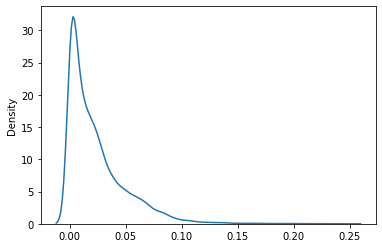

In [35]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

In [36]:
# Saving OOF predictions so stacking would be easier
pd.Series(oof.reshape(-1,)).to_csv('oof.csv', index=False)

In [38]:
# sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
# sub['target'] = preds.cpu().numpy().reshape(-1,)
# sub.to_csv('submission.csv', index=False)